# Takahashi Model Emulation (Python Implementation)

<p style="color:crimson;"> *To start using this notebook, please press the double <code>>></code> button.* </p> 

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import *
import matplotlib.pyplot as plt
%matplotlib inline
np.seterr(divide='ignore');

<code>Sample initial parameters:</code>

$
\begin{align}
La^{3+} = Nd^{3+} = 10~mol/m^3, && EDTA:REE = 0.5, && pH = 3, && Q = 30~mol/m^3 && Duration = 30000s
\end{align}
$


In [2]:
print('Please input the initial parameters for a binary La/Nd w/ EDTA separation: ')

La_conc = float(input('La initial concentration (mol/m^3): '))
Nd_conc = float(input('Nd initial concentration (mol/m^3): '))
EDTA_ratio = float(input('EDTA to REE Ratio (0 to 1.0): '))
pH = float(input('Initial pH: '))
Q = float(input('Ion exchange capacity (mol/m^3): '))
duration = float(input('Duration of Test (s): '))


Please input the initial parameters for a binary La/Nd w/ EDTA separation: 
La initial concentration (mol/m^3): 10
Nd initial concentration (mol/m^3): 10
EDTA to REE Ratio (0 to 1.0): 0.5
Initial pH: 4
Ion exchange capacity (mol/m^3): 50
Duration of Test (s): 35000


In [3]:
init_pmtrs = [La_conc, Nd_conc, Nd_conc*EDTA_ratio, (np.power(10, -pH)*1000), Q]

C_La_i = init_pmtrs[0]
C_Nd_i = init_pmtrs[1]
C_Na_i = init_pmtrs[2]
C_H_i = init_pmtrs[3]
Q = init_pmtrs[4]

# Constants for equations 2 through 6:

K_La_abs = np.power(10, 15.50)
K_Nd_abs = np.power(10, 16.61)
    
k1 = np.power(10, -2.00)
k2 = np.power(10, -2.67)
k3 = np.power(10, -6.16)
k4 = np.power(10, -10.26)

alpha = (k1*k2*k3*k4)/(k1*k2*k3*k4 + \
                           k1*k2*k3*C_H_i + \
                           k1*k2*np.power(C_H_i, 2) + \
                           k1*np.power(C_H_i, 3) + \
                           np.power(C_H_i, 4))


def eq_26(guess_26):
    
    C_LaEDTA = guess_26[0]
    C_NdEDTA = guess_26[1]
    C_EDTA_nc = guess_26[2]
    
    solution = np.zeros(3)
    
    solution[0] = C_La_i - (C_LaEDTA / (K_La_abs*alpha*C_EDTA_nc) + C_LaEDTA)
    solution[1] = C_Nd_i - (C_NdEDTA / (K_Nd_abs*alpha*C_EDTA_nc) + C_NdEDTA)
    solution[2] = C_Na_i - (C_LaEDTA + C_NdEDTA + C_EDTA_nc)

    return solution

In [4]:
guess = np.array([0.5,9.5,1])
guess2 = np.array([(0.01*C_La_i),(0.99*C_Nd_i),(C_Na_i)])

te_sol = fsolve(eq_26, guess2)
print('Concentration of LaEDTA =', te_sol[0])
print('Concentration of NdEDTA ion =', te_sol[1])
print('Concentration of EDTA non-complex =', te_sol[2])

print('solution: ', te_sol, '\n', 'equations:', eq_26(te_sol))

Concentration of LaEDTA = 0.3425706759687201
Concentration of NdEDTA ion = 3.1364454363562424
Concentration of EDTA non-complex = 1.520983887675038
solution:  [0.34257068 3.13644544 1.52098389] 
 equations: [1.15285559e-11 1.06084030e-10 0.00000000e+00]


In [5]:
C_La_computed = te_sol[0]/(K_La_abs*(alpha*te_sol[2]))
C_Nd_computed = te_sol[1]/(K_Nd_abs*(alpha*te_sol[2]))

def eq_79(mem_guess):

    C_La_mem = mem_guess[0]
    C_Nd_mem = mem_guess[1]
    C_Na_mem = mem_guess[2]
    C_H_mem = mem_guess[3]
    
    solution = np.zeros(4) # 4 equations to solve
    
    solution[0] = C_La_mem - (1.49 * np.power(C_H_mem, 3) * (C_La_computed/(np.power(C_H_i,3)))**0.8)
    solution[1] = C_Nd_mem - (1.15 * np.power(C_H_mem, 3) * (C_Nd_computed/(np.power(C_H_i,3)))**0.8)
    solution[2] = C_Na_mem - (0.32 * C_H_mem * (C_Na_i/C_H_i))
    solution[3] = Q - (3 * (C_La_mem+C_Nd_mem) + C_Na_mem + C_H_mem)
    
    return solution

In [6]:
sample_guess = np.array([17.3, 13.4, 7.81, 0.00488])
sample_guess2 = np.array([1,1,1,1]) # estimate membrane values
sample_guess3 = np.array([C_La_computed*1.7, C_Nd_computed*1.3, C_Na_i*1.25, C_H_i*4])

eq_79_sol = fsolve(eq_79, sample_guess3)

print('Concentration of La in membrane=', eq_79_sol[0])
print('Concentration of Nd in membrane=', eq_79_sol[1])
print('Concentration of EDTA in membrane =', eq_79_sol[2])
print('Concentration of H in membrane =', eq_79_sol[3])

print('solution: ', eq_79_sol, '\n', 'equations:', eq_79(eq_79_sol))

Concentration of La in membrane= 9.918616301246539
Concentration of Nd in membrane= 5.82522498528784
Concentration of EDTA in membrane = 2.605624602726461
Concentration of H in membrane = 0.1628515376704038
solution:  [9.9186163  5.82522499 2.6056246  0.16285154] 
 equations: [-1.24344979e-14 -7.99360578e-15  0.00000000e+00 -7.10542736e-15]


In [7]:
#List of constant values.
surface_area = 0.005 
valence = 3
D_La = 4.4e13
D_Nd = 5.2e13
D_Na = 1.9e15
D_H = 1.1e16

#C_La_mem0 = eq_79_sol[0] 
#C_Nd_mem0 = eq_79_sol[1] 
#C_Na_mem0 = eq_79_sol[2]
#C_H_mem0 = eq_79_sol[3]

K_H_La = 1.49
K_H_Nd = 1.15
K_H_Na = 0.32

I = 20
F = 96485
V = 0.00125

# IVP parameters
n = duration
tspan = np.linspace(0, n, 100)
y0 = [eq_79_sol[0], eq_79_sol[1], eq_79_sol[2], eq_79_sol[3]]
ytest = [9.3, 2.2, 5, 1]


In [8]:
# Dynamics function
def RKG_Takahashi(z, t):
    '''
        z[0] = C_La
        z[1] = C_Nd
        z[2] = C_Na
        z[3] = C_H
        
        f1 = dC_La/dt
        f2 = dC_Nd/dt
        f3 = dC_Na/dt
        f4 = dC_H/dt
        
        ** Need to convert f5-f8 into an array**
    '''
    
    C_La_mem, C_Nd_mem, C_Na_mem, C_H_mem = z # initial values
    
    f1 = surface_area * ((valence * D_La * C_La_mem) / \
                         (valence**2 * D_La * C_La_mem + \
                          valence**2 * D_Nd * C_Nd_mem + \
                          D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
    
    f2 = surface_area * ((valence * D_Nd * C_Nd_mem) / \
                         (valence**2 * D_Nd * C_Nd_mem + \
                          valence**2 * D_La * C_La_mem + \
                          D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
    
    f3 = surface_area * ((D_Na * C_Na_mem) / (valence**2 * D_La * C_La_mem + \
                                              valence**2 * D_Nd * C_Nd_mem + \
                                              D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
    
    f4 = surface_area * ((D_H * C_H_mem) / (valence**2 * D_La * C_La_mem + \
                                            valence**2 * D_Nd * C_Nd_mem + \
                                            D_Na * C_Na_mem + D_H * C_H_mem)) * I/F * 1/-V
     
    return [f1, f2, f3, f4]

In [9]:
sol = odeint(RKG_Takahashi, y0, tspan)

In [10]:
type(sol)

numpy.ndarray

In [11]:
sol

array([[ 9.91861630e+00,  5.82522499e+00,  2.60562460e+00,
         1.62851538e-01],
       [ 9.88931331e+00,  5.80489170e+00,  2.49698709e+00,
         1.27266005e-01],
       [ 9.85873835e+00,  5.78368748e+00,  2.38813783e+00,
         9.83209659e-02],
       [ 9.82695082e+00,  5.76165499e+00,  2.27966512e+00,
         7.51218541e-02],
       [ 9.79401437e+00,  5.73883984e+00,  2.17212112e+00,
         5.67887699e-02],
       [ 9.75999287e+00,  5.71528771e+00,  2.06600509e+00,
         4.24938461e-02],
       [ 9.72494713e+00,  5.69104213e+00,  1.96175350e+00,
         3.14875153e-02],
       [ 9.68893276e+00,  5.66614297e+00,  1.85973637e+00,
         2.31133499e-02],
       [ 9.65199893e+00,  5.64062560e+00,  1.76025866e+00,
         1.68127924e-02],
       [ 9.61418799e+00,  5.61452063e+00,  1.66356503e+00,
         1.21223066e-02],
       [ 9.57553573e+00,  5.58785408e+00,  1.56984644e+00,
         8.66545202e-03],
       [ 9.53607203e+00,  5.56064791e+00,  1.47924737e+00,
      

Text(0.5, 1.0, 'Concentration Profile')

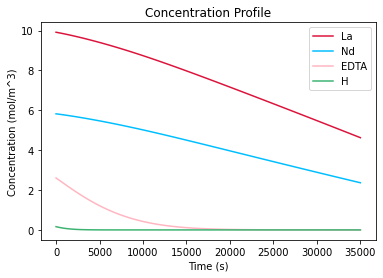

In [12]:
#plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(tspan, sol[:,0], 'crimson')
plt.plot(tspan, sol[:,1], 'deepskyblue')
plt.plot(tspan, sol[:,2], 'lightpink')
plt.plot(tspan, sol[:,3], 'mediumseagreen')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m^3)')
plt.legend(['La', 'Nd', 'EDTA', 'H'])
plt.title(('Concentration Profile'))


__Computed Separation Factor__

Takahashi _et al._ calculated separation factor by simply dividing the flux of the REE with higher permeation over the lower permeation REE (e.g. it would be $S_{J_M/J_{RE}} = \frac{J_{La}}{J_{Nd}}$ or $S_{J_{Nd}/J_{Gd}} = \frac{J_{Nd}}{J_Gd}$, $S_{J_{Nd}/J_{Y}} = \frac{J_{Nd}}{J_Y}$

Do we proceed to assume the membrane flux is the one we use in equations 19-20?

$S_{J_M/J_{RE}} = \frac{J_{La}}{J_{Nd}}$

In [13]:
J_La = sol[99][0]
J_Nd = sol[99][1]

S_La_Nd = (J_La/surface_area*V)/(J_Nd/surface_area*V)
print("Separation Factor of La over Nd = " + "\033[3;37;40m" + str(S_La_Nd))

Separation Factor of La over Nd = 1.9558742200714123


### From (1) Takahashi et al. (1993) Reference. SEPARATION OF LIGHT RARE-EARTH ELEMENTS FROM RARE-EARTH MIXTURE SOLUTION BY USE OF ELECTRODIALYSIS WITH COMPLEXING AGENTS.

### Attempting to solve the following DE for the REE ions $La^{3+}$ and $Nd^{3+}$:

![](diff_eqn_16.png "picture")

#### Solving Takahashi Model Equations 2-6 Simultaneously

<code>From their paper:</code>

<img src="takahashi_26.png" width="600">

#### Solving Takahashi Model Equations 7-9 Simultaneously

<img src="takahashi_eq79.PNG" width="600">

Notes: three equations version appears to be better, odeint better than solve_ivp. Still need to figure out how to generate good guess values.

<img src="state_machine_takahashi.PNG" width="750">